# Install NeoLibrary, if necessary

In [1]:
!pip install py2neo

     |████████████████████████████████| 177 kB 2.0 MB/s eta 0:00:01


# Import main neo class

In [2]:
from py2neo import Graph

# Connect to Neo4J Database

In [4]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "Rosepoint3873"))

# Start with clean db. Delete existing data

In [6]:
cypher = "MATCH (n) DETACH DELETE n"
graph.run(cypher)

(No data)

# LOAD Data from Spedddating.csv file
### The following consists of two calls that can be combined in the browser command window.  The first call LOAD ...) reads in the csv file from the filesystem in the container.  The second calls (MERGE ...) creates the nodes and relationships.

In [9]:
cypher = 'LOAD CSV WITH HEADERS FROM "file:///SpeedDatingData.csv" AS row \
WITH row WHERE NOT row.age IS null AND NOT row.iid IS null AND NOT row.pid IS null \
AND NOT row.age_o IS null and NOT row.race IS null and NOT row.race_o IS null \
and NOT row.match IS null and NOT row.int_corr IS null and NOT row.gender is null \
AND NOT row.samerace IS null AND NOT row.age_o IS null \
MERGE(p1 :Person {id:row.iid,age:toInteger(row.age), race:toInteger(row.race) }) \
MERGE( p2: Person {id:row.pid, age:toInteger(row.age_o), race:toInteger(row.race_o)}) \
MERGE((p1) - [:Date {match: toInteger(row.match), int_corr: row.int_corr, \
race_diff:toInteger(row.samerace), age_diff:abs(toInteger(row.age)- toInteger(row.age_o))}] -> (p2)) \
SET p1.gender = toInteger(row.gender)'
graph.run(cypher)

(No data)

# Provide the schema

In [11]:
cypher = "call db.schema.visualization()"
graph.run(cypher)

nodes,relationships
"[(_-13:Movie {constraints: [], indexes: ['released'], name: 'Movie'}), (_-14:Person {constraints: [], indexes: [], name: 'Person'})]",[(_-14)-[:Date {}]->(_-14)]


# Determine the ratio of Female to Males

In [10]:
cypher = "MATCH (n:Person) \
WITH tofloat(count(CASE WHEN n.gender=1  THEN 1.0 END)) as maleCount, tofloat(count(CASE WHEN n.gender = 0 \
THEN 1.0 END)) as femaleCount \
RETURN maleCount, femaleCount, maleCount/femaleCount as maleToFemaleRatio"
graph.run(cypher)

maleCount,femaleCount,maleToFemaleRatio
274.0,268.0,1.0223880597014925


# Determining the % of dates that were matches (both selected eachother) 
## Select columns that would prove useful in predicting a match.
## Explain your reasoning.

In [12]:
cypher = "MATCH (p1:Person)-[r:Date]->(p2:Person) \
WITH  count(r) as total_dates \
MATCH (p1)-[r2:Date]->(p2) \
WHERE r2.match=1 \
WITH  COUNT(r2) as matches, total_dates \
RETURN (tofloat(matches)*100 / tofloat(total_dates)) AS match_percentage"
graph.run(cypher)

match_percentage
16.47029945999018


## In order to find useful columns for predicting a match, lets find coorelation between each feature and match column



dec_o      0.522326
dec        0.521943
like_o     0.305853
like       0.305723
fun_o      0.277700
             ...   
shar7_2   -0.060104
go_out    -0.060526
date      -0.063610
shar2_3   -0.077851
met_o     -0.106569
Name: match, Length: 190, dtype: float64


<ipython-input-16-fa91be9a5ef0>:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(data.corr(), dtype=np.bool)


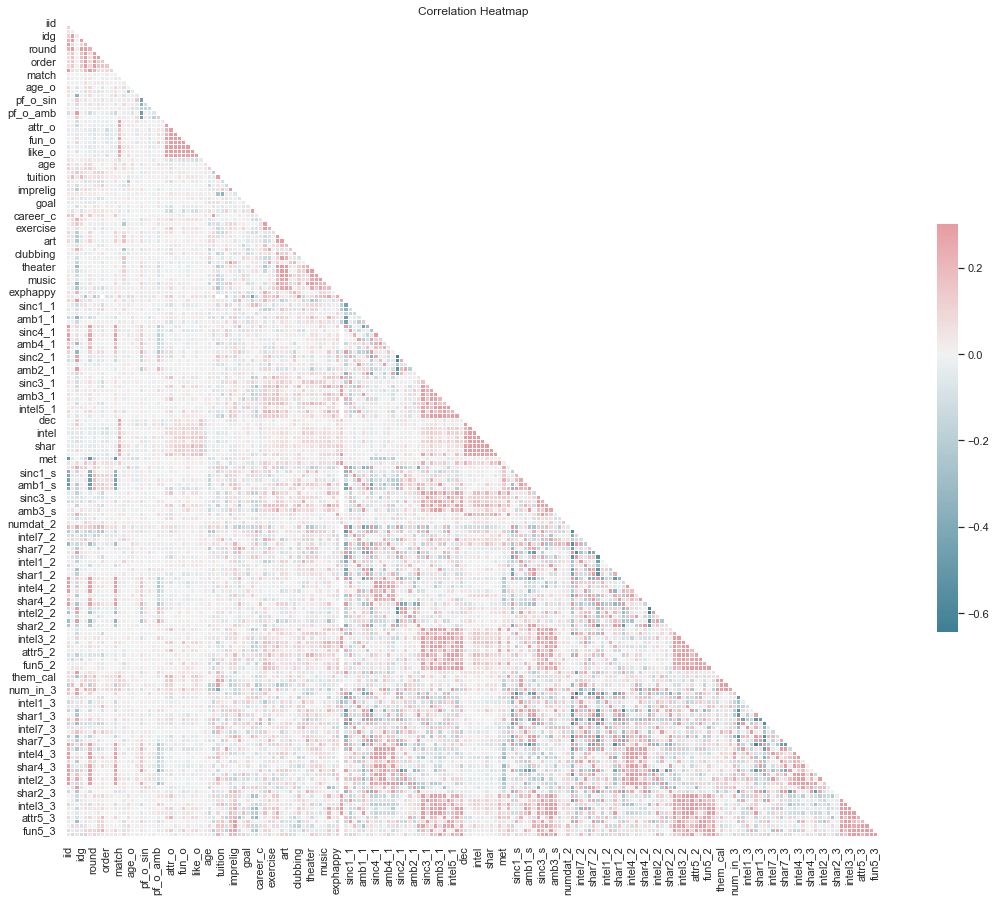

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data into a pandas DataFrame
data = pd.read_csv("https://raw.githubusercontent.com/rsadaphule/NoSqlExercise/main/data/SpeedDatingData.csv")

# Calculate the correlation between each column and the "match" column
correlations = data.corr()["match"].drop("match")

# Order the columns in descending order of correlation score
sorted_correlations = correlations.sort_values(ascending=False)

# Print the sorted correlations
print(sorted_correlations)

# Plot the correlation heatmap using seaborn
sns.set(style="white")
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap")
plt.show()

# As you can see here are some columns that are highly coorrelated with match column and hence should be used as training


In [17]:
# Print the sorted correlations
print(sorted_correlations[0:10])

dec_o     0.522326
dec       0.521943
like_o    0.305853
like      0.305723
fun_o     0.277700
fun       0.277545
shar_o    0.270840
shar      0.270679
attr_o    0.260837
attr      0.260676
Name: match, dtype: float64


# Write a supervised training algorithm for top 10 training features

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Select the top 10 features with the highest correlation with "match"
top_10_features = ['int_corr', 'samerace', 'like', 'prob', 'met', 'attr', 'sinc', 'intel', 'fun', 'amb']

# Check for missing or infinite values and replace them with the mean value for each column
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(data.mean())

# Create the feature matrix and target vector
X = data[top_10_features]
y = data['match']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model on the training data
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8305489260143198


<ipython-input-20-0c735a15e6d7>:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data = data.fillna(data.mean())
